In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# The following code will add the parent directory (i.e., '<Github Home>/market-modeling/') to the path Python uses to search for packages
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

In [3]:
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

from models.geom_growth_models.Models import DependentModel
from examples import create_market, plot_train_hist, plot_covariance_matrix, plot_predictions

In [4]:
DEBUG = False
market = create_market('../data', 'popular_stocks', 'growth_timeseries', DEBUG)

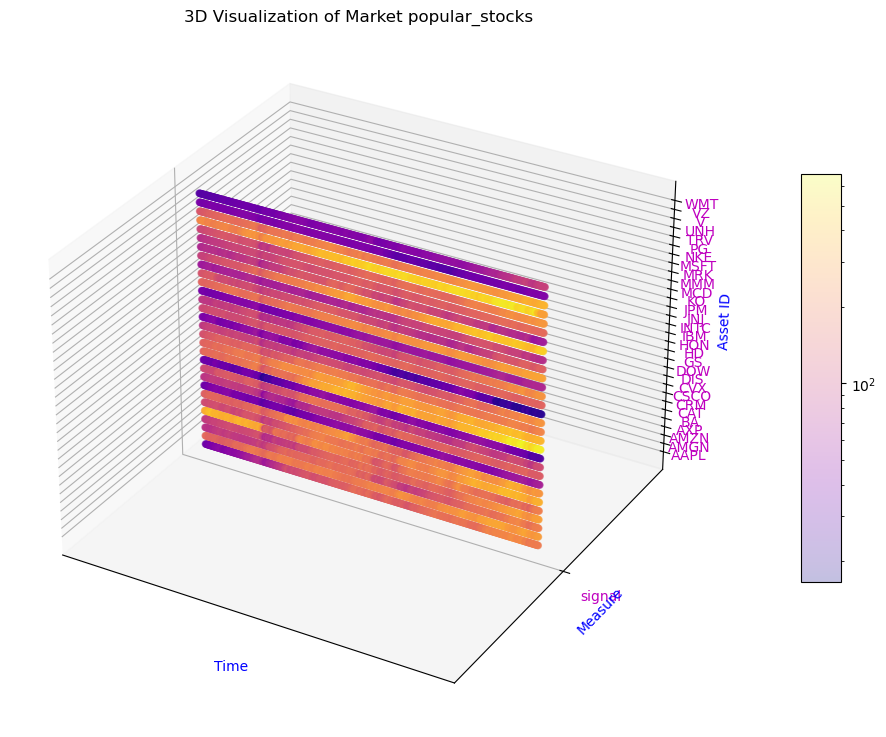

In [5]:
market.align_timeseries(True)
market.display_market(show_indicators=False)

In [6]:
train_split, val_split, test_split = market.train_test_split(0.2, 0.1)

## Fit Dependent Model to the Most Recent Data

In [7]:
dep_model = DependentModel()
(mkt_mu, mkt_Sigma), train_hist = dep_model.fit_local_params(None, test_split, train_epochs=20)

100%|██████████| 20/20 [00:09<00:00,  2.16it/s, train_loss=2.89e+4, val_loss=nan, train_MAE=0.274, val_MAE=nan]


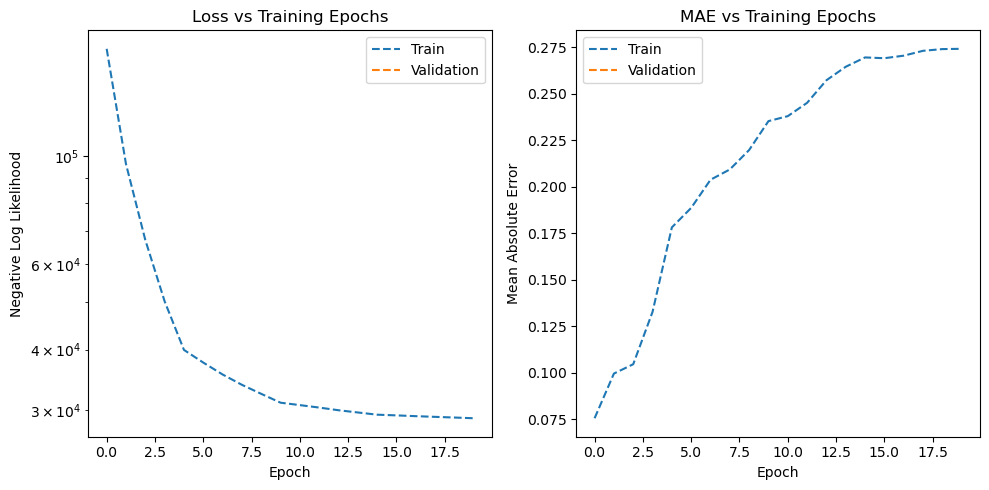

In [8]:
plot_train_hist(train_hist)

In [9]:
summ_df = pd.DataFrame({
	'ticker': market.xarray_ds['ID'].values,
	'mean': mkt_mu,
	'sigma': np.linalg.norm(mkt_Sigma, axis=0)
})

summ_df

,ticker,mean,sigma
0,AAPL,-0.000134,0.001285
1,AMGN,-0.000022,0.000653
2,AMZN,0.000546,0.001281
3,AXP,0.000298,0.001456
4,BA,0.002086,0.001409
5,CAT,-0.000288,0.001143
6,CRM,-0.000855,0.001086
7,CSCO,0.000846,0.000819
8,CVX,0.000196,0.000871
9,DIS,0.000672,0.001172


<Figure size 640x480 with 0 Axes>

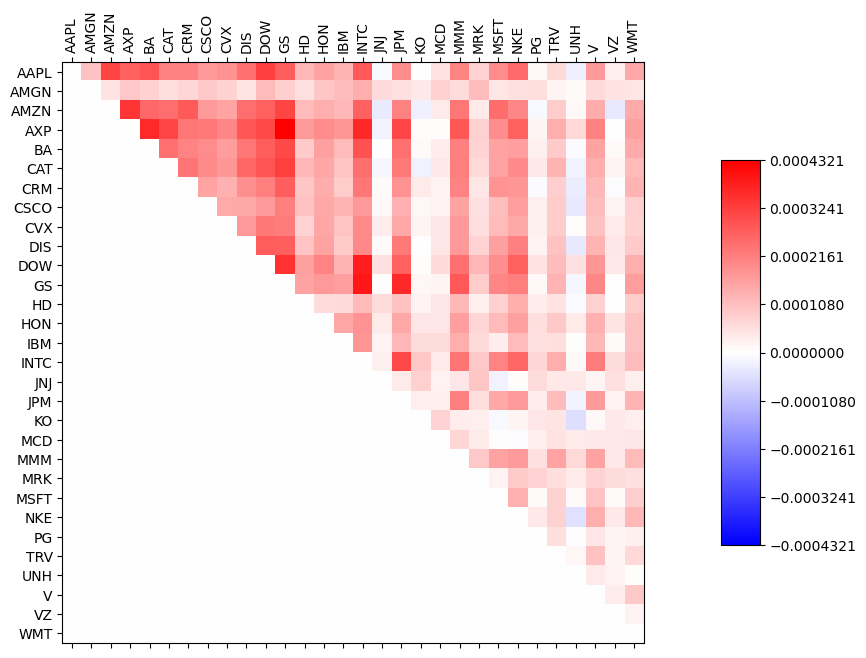

In [10]:
plot_covariance_matrix(mkt_Sigma, summ_df);

## Forecast Near-Future

In [11]:
LAST_DATE = datetime.fromtimestamp(int(market.xarray_ds['time'].max().to_numpy())//1e9)
dates_to_sim = pd.to_datetime(
  pd.Series([
	  LAST_DATE+timedelta(days=2),
	  LAST_DATE+timedelta(days=5),
	  LAST_DATE+timedelta(days=20),
	  LAST_DATE+timedelta(days=30),
  ], name='dates'),
  format='%m-%d-%Y'
)

prev_time, prev_state = market.get_market_state_before_date(min(dates_to_sim))
prev_signals = prev_state.sel(variable='signal').to_numpy()

sim_dates = pd.concat((pd.Series(prev_time, name='dates'), dates_to_sim))

In [12]:
sim_res = dep_model.simulate(
	None, prev_signals, sim_dates, num_sims=20,
	mu=mkt_mu, Sigma=mkt_Sigma
)
sim_counterfact = dep_model.simulate(
	None, prev_signals, sim_dates, num_sims=1, add_BM=False,
	mu=mkt_mu, Sigma=mkt_Sigma
)

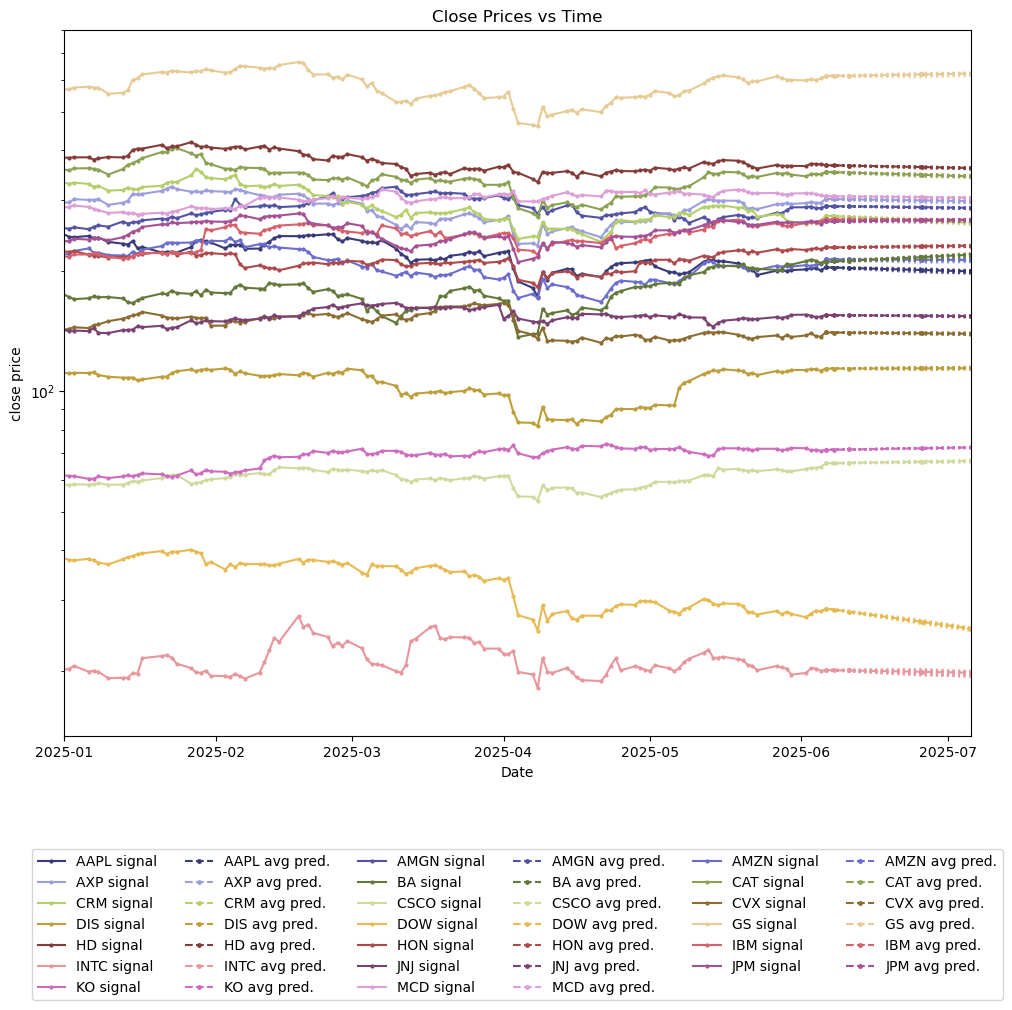

In [13]:
plot_predictions(market, sim_dates, sim_res, sim_counterfact)